In [1]:
# Libraries and file path
import torch
import torch.nn as nn
import torch.optim as optim

import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score

from bayes_opt import BayesianOptimization

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [2]:
# Load files
log_file_path = '/Users/hwaaaaanii/Desktop/KAIST./Lectures./Data-Driven Decision Making and Control/IE437_HW2/data/log.csv'
query_file_path = '/Users/hwaaaaanii/Desktop/KAIST./Lectures./Data-Driven Decision Making and Control/IE437_HW2/data/query.csv'

log = pd.read_csv(log_file_path)
query = pd.read_csv(query_file_path)

Best_score = {}
Best_query = {}
Model_score = {}

## Data Description

In [3]:
log.describe()

,A,B,C,D,E,score
count,9992.000000,9992.000000,9992.000000,9992.000000,9992.000000,9992.000000
mean,0.498985,0.498149,0.494426,0.495300,0.498725,71.645244
std,0.291844,0.289512,0.289011,0.289082,0.289978,4.333470
min,0.000064,0.000010,0.000397,0.000126,0.000233,62.944380
25%,0.244372,0.247665,0.241093,0.242532,0.245855,68.460217
50%,0.499789,0.498503,0.491682,0.494536,0.497319,70.780107
75%,0.754511,0.749839,0.747202,0.743745,0.750852,74.079871
max,0.999860,0.999969,0.999882,0.999996,0.999987,89.830920


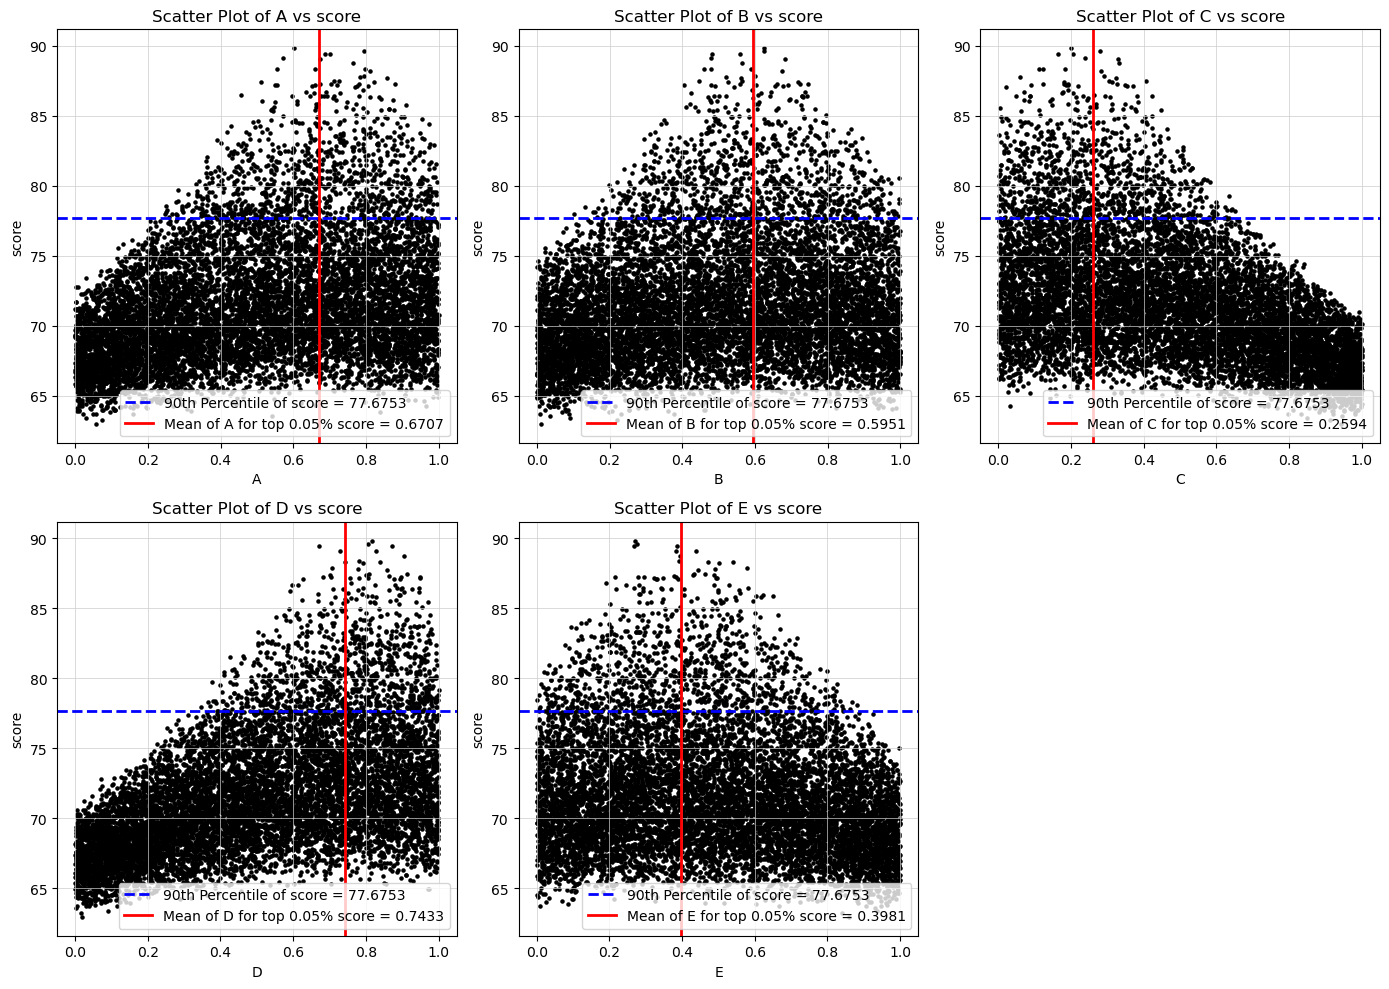

In [4]:
columns = ['A','B','C','D','E']

plt.figure(figsize=(14, 10))

for idx, column in enumerate(columns) :
    log_column = log[column]
    
    plt.subplot(2, 3, idx+1)

    threshold= log['score'].quantile(0.90)
    mean_log = log[log['score'] >= threshold][column].mean()

    plt.scatter(log_column, log['score'], color = 'black', s = 5)

    plt.axhline(y = threshold, color = 'b', linestyle = '--', label = f'90th Percentile of score = {round(threshold, 4)}', linewidth = 2)
    plt.axvline(x = mean_log, color = 'r', linestyle = '-', label = f'Mean of {column} for top 0.05% score = {round(mean_log, 4)}', linewidth = 2)


    plt.title(f'Scatter Plot of {column} vs score')
    plt.xlabel(f'{column}')
    plt.ylabel('score')
    plt.legend(fontsize = 'medium', loc = 'lower right')
    plt.grid(True,  color = '#CCCCCC', linestyle = '-', linewidth = 0.5)

plt.tight_layout()
plt.show()


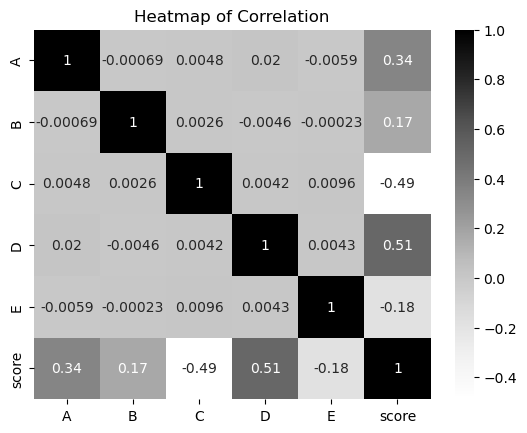

In [5]:
corr = log.corr()

sns.heatmap(corr, annot = True, cmap = 'Greys')
plt.title('Heatmap of Correlation')
plt.show()

# Raw data vs Top 10% data Testing

In [6]:
# n_1 = int(len(log['score'])*0.1)
# n_2 = int(len(log['score'])*0.01)
# score_top_10 = log.nlargest(n_1, 'score')
# score_top_1 = log.nlargest(n_2, 'score')

In [7]:
# print(score_top_10)
# score_top_10.describe()

In [8]:
# print(score_top_1)
# score_top_1.describe()

In [9]:
p = 5
n_1 = int(len(log['score'])*0.1)
n_2 = int(len(log['score'])*0.01)
score_top_10 = log.nlargest(n_1, 'score')
score_top_1 = log.nlargest(n_2, 'score')

X = score_top_10[['A', 'B', 'C', 'D', 'E']]
y = score_top_10['score']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### 1. Machine Learning (Linear Regression, Random Forest, Support Vector Regression)

In [10]:
print('----------------------------------------------------------------------------')
print('-------------------------Processing Linear Regression-----------------------')

data_step = 1


if data_step == 0 :
    X_regression = log[['A', 'B', 'C', 'D', 'E']]
    y_regression = log['score']
    label = 'Raw data'
else : 
    X_regression = score_top_10[['A', 'B', 'C', 'D', 'E']]
    y_regression = score_top_10['score']
    label = 'Top 10% \data'


# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_regression, y_regression, test_size=0.2, random_state=42)

# Training the linear regression model
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

# Predicting 'score' for the test set
y_pred_test = linear_model.predict(X_test)

# Predicting 'score' for the entire dataset
predicted_scores = linear_model.predict(X_regression)
X_regression['predicted_score'] = predicted_scores

# Extracting the top 10 rows with the highest predicted 'score'
top_predictions_regression = X_regression.nlargest(10, 'predicted_score')

# Displaying the top 10 predictions
print(top_predictions_regression[['A', 'B', 'C', 'D', 'E', 'predicted_score']])

# Calculating the average of the top 10 predicted 'scores'
average_score = top_predictions_regression['predicted_score'].mean()
Best_score[f'Linear Regression for {label}'] = average_score
Best_query[f'Linear Regression for {label}'] = top_predictions_regression[['A', 'B', 'C', 'D', 'E', 'predicted_score']]

print(f"\nAverage score of top 10 predictions using Linear Regression for {label} :", average_score)

# Calculating and displaying the MSE and R^2 for the test set
mse = mean_squared_error(y_test, y_pred_test)
r2 = r2_score(y_test, y_pred_test)
r2 = 1 - (1 - r2) * (n_1 - 1) / (n_1 - p - 1)

print("Mean Squared Error (MSE) on Test Set :", mse)
print("Adujsted R^2 Score on Test Set :", r2)
model_score = r2 * (2 * average_score * (1 / np.sqrt(mse))) / (average_score + (1 / np.sqrt(mse)))
print(f'Model Score : {model_score}')
Model_score[f'Linear Regression for {label}'] = model_score

print('-----------------------Linear Regression Process Done-----------------------')
print('----------------------------------------------------------------------------\n\n')

----------------------------------------------------------------------------
-------------------------Processing Linear Regression-----------------------
             A         B         C         D         E  predicted_score
7867  0.990510  0.741040  0.125927  0.958982  0.509854        82.568007
5723  0.894452  0.878624  0.077888  0.964411  0.623175        82.496247
187   0.802315  0.828741  0.008191  0.972973  0.561132        82.493080
5417  0.812533  0.742994  0.023858  0.979701  0.412444        82.476315
7752  0.936599  0.914324  0.105209  0.972479  0.180965        82.452985
5106  0.925213  0.446800  0.043257  0.913535  0.032051        82.447241
6426  0.970249  0.421977  0.027746  0.820723  0.637021        82.432331
3584  0.971169  0.542276  0.150233  0.927966  0.718677        82.426432
9231  0.920868  0.281228  0.032551  0.865099  0.466281        82.424248
8120  0.926459  0.623024  0.135016  0.976300  0.272531        82.414106

Average score of top 10 predictions using Linear Regr

In [11]:
print('----------------------------------------------------------------------------')
print('---------------------------Processing Random Forest-------------------------')

# Assume the training data (X_train, y_train) is already defined from previous context
rf_model = RandomForestRegressor(n_estimators=1, random_state=42)
rf_model.fit(X_train, y_train)

# Predicting 'score' for the test set using the trained Random Forest model
y_pred_test_rf = rf_model.predict(X_test)

# Calculating MSE and R^2 for the test set predictions
mse_rf = mean_squared_error(y_test, y_pred_test_rf)
r2_rf = r2_score(y_test, y_pred_test_rf)
r2_rf = 1 - (1 - r2_rf) * (n_1 - 1) / (n_1 - p - 1)

# Objective function to maximize using Bayesian Optimization
def rf_score(A, B, C, D, E):
    X_new = [[A, B, C, D, E]]
    return rf_model.predict(X_new)[0]

# Parameter bounds for Bayesian Optimization
pbounds = {'A': (0, 1), 'B': (0, 1), 'C': (0, 1), 'D': (0, 1), 'E': (0, 1)}

print('------------Finding Optimal Points by using Bayesian Optimization------------')

# Bayesian Optimization object creation
optimizer = BayesianOptimization(
    f=rf_score,
    pbounds=pbounds,
    verbose=1,
    random_state=42
)

# Optimization execution
optimizer.maximize(
    init_points=5,
    n_iter=200
)

# Extracting the top 10 results based on the target (predicted score)
top_results = sorted(optimizer.res, key=lambda x: x['target'], reverse=True)[:10]

# Preparing the DataFrame to display the top results
df = {
    "A": [],
    "B": [],
    "C": [],
    "D": [],
    "E": [],
    "score": []
}

for result in top_results:
    df['A'].append(result['params']['A'])
    df['B'].append(result['params']['B'])
    df['C'].append(result['params']['C'])
    df['D'].append(result['params']['D'])
    df['E'].append(result['params']['E'])
    df['score'].append(result['target'])

top_predictions_rf = pd.DataFrame(df)
print(top_predictions_rf)

# Calculating the average score of the top 10 predictions
average_score = np.mean(top_predictions_rf['score'])
Best_score['Random Forest'] = average_score
Best_query['Random Forest'] = top_predictions_rf

print("\nAverage score of top 10 predictions using Random Forest: ", average_score)
print(f"Mean Squared Error (MSE) on Test Set: {mse_rf}")
print(f"R^2 Score on Test Set: {r2_rf}")
model_score = r2_rf * (2 * average_score * (1 / np.sqrt(mse_rf))) / (average_score + (1 / np.sqrt(mse_rf)))
print(f'Model Score : {model_score}')

print('-------------------------Random Forest Process Done-------------------------')
print('----------------------------------------------------------------------------')

----------------------------------------------------------------------------
---------------------------Processing Random Forest-------------------------
------------Finding Optimal Points by using Bayesian Optimization------------
|   iter    |  target   |     A     |     B     |     C     |     D     |     E     |
-------------------------------------------------------------------------------------
| 3         | 78.65     | 0.02058   | 0.9699    | 0.8324    | 0.2123    | 0.1818    |
| 6         | 80.9      | 0.3871    | 0.6911    | 0.258     | 0.832     | 0.6098    |
| 7         | 81.06     | 0.4042    | 0.7187    | 0.1986    | 0.8969    | 0.6691    |
| 9         | 88.32     | 0.6619    | 0.6384    | 0.09157   | 1.0       | 0.4871    |
| 18        | 89.41     | 0.6771    | 0.5866    | 0.214     | 1.0       | 0.3645    |
| 60        | 89.83     | 0.621     | 0.5894    | 0.1098    | 0.7936    | 0.434     |
          A         B         C         D         E     score
0  0.620983  0.589

In [12]:
print('----------------------------------------------------------------------------')
print('---------------------Processing Support Vector Regression-------------------')

# Training the Support Vector Regression (SVR) model with chosen parameters
model = SVR(kernel='rbf', C=195, epsilon=0.1)
model.fit(X_train, y_train)

# Predicting 'score' for the test set using the trained SVR model
y_pred_test_svr = model.predict(X_test)

# Objective function to maximize using Bayesian Optimization
def svr_score(A, B, C, D, E):
    X_new = [[A, B, C, D, E]]
    return model.predict(X_new)[0]

# Parameter bounds for Bayesian Optimization
pbounds = {'A': (0, 1), 'B': (0, 1), 'C': (0, 1), 'D': (0, 1), 'E': (0, 1)}

print('------------Finding Optimal Points by using Bayesian Optimization------------')

# Bayesian Optimization object creation
optimizer = BayesianOptimization(
    f=svr_score,
    pbounds=pbounds,
    verbose=1,
    random_state=42
)

# Optimization execution
optimizer.maximize(
    init_points=5,
    n_iter=200
)

# Extracting the top 10 results based on the target (predicted score)
top_results = sorted(optimizer.res, key=lambda x: x['target'], reverse=True)[:10]

# Preparing the DataFrame to display the top results
df = {
    "A": [],
    "B": [],
    "C": [],
    "D": [],
    "E": [],
    "score": []
}

for result in top_results:
    df['A'].append(result['params']['A'])
    df['B'].append(result['params']['B'])
    df['C'].append(result['params']['C'])
    df['D'].append(result['params']['D'])
    df['E'].append(result['params']['E'])
    df['score'].append(result['target'])

top_predictions_bayes = pd.DataFrame(df)
print(top_predictions_bayes)

# Calculating the average score of the top 10 predictions
average_score = np.mean(top_predictions_bayes['score'])
Best_score['Bayesian Optimization'] = average_score
Best_query['Bayesian Optimization'] = top_predictions_bayes

print(f"Average score of top 10 predictions using Bayesian Optimization: {average_score}")

# Calculating MSE and R^2 for the test set predictions
mse_svr = mean_squared_error(y_test, y_pred_test_svr)
r2_svr = r2_score(y_test, y_pred_test_svr)
r2_svr = 1 - (1 - r2_svr) * (n_1 - 1) / (n_1 - p - 1)

print(f"Mean Squared Error (MSE) on Test Set: {mse_svr}")
print(f"R^2 Score on Test Set: {r2_svr}")
model_score = r2_svr * (2 * average_score * (1 / np.sqrt(mse_svr))) / (average_score + (1 / np.sqrt(mse_svr)))
print(f'Model Score : {model_score}')


print('-------------------Support Vector Regression Process Done-------------------')
print('----------------------------------------------------------------------------')

----------------------------------------------------------------------------
---------------------Processing Support Vector Regression-------------------
------------Finding Optimal Points by using Bayesian Optimization------------
|   iter    |  target   |     A     |     B     |     C     |     D     |     E     |
-------------------------------------------------------------------------------------
| 2         | 81.28     | 0.156     | 0.05808   | 0.8662    | 0.6011    | 0.7081    |
| 14        | 81.77     | 0.0       | 0.1556    | 1.0       | 0.4487    | 0.9928    |
| 20        | 82.3      | 0.3991    | 0.0       | 1.0       | 0.4814    | 1.0       |
| 23        | 83.4      | 0.5178    | 0.2024    | 1.0       | 0.8705    | 1.0       |
| 26        | 83.63     | 0.4169    | 0.0       | 1.0       | 1.0       | 1.0       |
| 65        | 84.92     | 0.7756    | 0.6153    | 0.4367    | 0.8627    | 0.526     |
| 70        | 86.63     | 0.8078    | 0.6823    | 0.3515    | 0.6821    | 0.4597

### 2. Deep Learning (Base, Imporved, Complex Neural Network)

#### 2-1. Base Neural Network

In [13]:
# # Define a Simple Neural Network
# class BaseMLP(nn.Module):
#     def __init__(self, input_dim, output_dim, hidden_dim):
#         super(BaseMLP, self).__init__()

#         self.model = nn.Sequential(nn.Linear(input_dim, hidden_dim),
#                                    nn.ReLU(),
#                                    nn.Linear(hidden_dim, hidden_dim),
#                                    nn.ReLU(),
#                                    nn.Linear(hidden_dim, output_dim))
    
#     def forward(self, x):
#         return self.model(x)
    

# # Define a Improved Neural Network
# class ImprovedMLP(nn.Module):
#     def __init__(self, input_dim, output_dim, hidden_dim):
#         super(ImprovedMLP, self).__init__()

#         self.model = nn.Sequential(
#             nn.Linear(input_dim, hidden_dim),
#             nn.ReLU(),
#             nn.BatchNorm1d(hidden_dim),  
#             nn.Dropout(0.5),            

#             nn.Linear(hidden_dim, hidden_dim),
#             nn.ReLU(),
#             nn.BatchNorm1d(hidden_dim),  
#             nn.Dropout(0.5),            

#             nn.Linear(hidden_dim, output_dim)
#         )
    
#     def forward(self, x):
#         return self.model(x)
    

# # Define a Complex Neural Network
# class ComplexMLP(nn.Module):
#     def __init__(self, input_dim, output_dim, hidden_dims):
#         super(ComplexMLP, self).__init__()

#         layers = []
#         prev_dim = input_dim
        
#         # 동적으로 여러 층을 추가
#         for hidden_dim in hidden_dims:
#             layers.append(nn.Linear(prev_dim, hidden_dim))
#             layers.append(nn.BatchNorm1d(hidden_dim))  # 배치 정규화
#             layers.append(nn.PReLU())  # PReLU 활성화
#             layers.append(nn.Dropout(0.3))  # 드롭아웃 추가
#             prev_dim = hidden_dim
        
#         # 최종 출력 층
#         layers.append(nn.Linear(hidden_dims[-1], output_dim))
        
#         # Sequential 모듈에 층 추가
#         self.model = nn.Sequential(*layers)
    
#     def forward(self, x):
#         return self.model(x)
    
# # Split into Train and Validation set
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("mps") if torch.backends.mps.is_available() else "cpu"


# data = torch.from_numpy(log.values).float().to(device)
# X, y = data[:, :5], data[:, -1:]

# X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)  # 0.25 * 0.8 = 0.2

# # Convert numpy arrays to torch tensors
# X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
# y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1).to(device)

# X_val_tensor = torch.tensor(X_val, dtype=torch.float32).to(device)
# y_val_tensor = torch.tensor(y_val, dtype=torch.float32).view(-1, 1).to(device)

# X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
# y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1).to(device)


# # CUDA_VISIBLE_DEVICES=3 python 20243835.py

In [14]:
# # Experiment settings
# model_selection = 'Base' # Options : 'Base', 'Improved', 'Complex'
# optimizer_selection = 'Adam' # Options : 'Adam', 'AdamW'

# # Hyperparameters 
# batch_size = 256
# training_step = 50000
# validation_interval = 2000
# lr = 1e-4

# criterion = nn.MSELoss()

# # Select Models and Optimizer
# if model_selection == 'Base' :
#     model = BaseMLP(input_dim=5, output_dim=1, hidden_dim=64)
# elif model_selection == 'Improved' : 
#     model = ImprovedMLP(input_dim=5, output_dim=1, hidden_dim=64)
# elif model_selection == 'Complex' :
#     model = ComplexMLP(input_dim=5, output_dim=1, hidden_dims=[128, 256, 64])

# if optimizer_selection == 'Adam' :
#     optimizer = optim.Adam(model.parameters(), lr=lr)
# elif optimizer_selection == 'AdamW' :
#     optimizer = optim.AdamW(model.parameters(), lr=lr)
    

# print(f'Device : {device}')

In [15]:
# # Train a neural network
# model = model.to(device)

# train_losses = []
# valid_losses = []
# for step in range(training_step):
#     idx = torch.randint(0, len(X_train_tensor), size=(batch_size, ))
    
    
#     batch_train_x, batch_train_y = X_train_tensor[idx], y_train_tensor[idx]
#     batch_pred_y = model(batch_train_x)

#     optimizer.zero_grad()

#     train_loss = criterion(batch_train_y, batch_pred_y)
#     train_loss.backward()
    
#     optimizer.step()

#     train_losses.append(train_loss.item())

#     if (step+1) % validation_interval == 0:
#         valid_loss = criterion(model(X_val_tensor), y_val_tensor)
#         valid_losses.append(valid_loss.item())

#         print(f"Step: {step+1}/{training_step}\tTrain Loss: {train_losses[-1]:.2f}\tValid Loss: {valid_losses[-1]:.2f}")

In [16]:
# print('-----------------------------Experiment setting------------------------------')
# print(f'Model : {model}')
# print(f'Optimizer : {optimizer}')
# print(f'Batch size : {batch_size}')
# print(f'Training Step : {training_step}')
# print(f'Learning rate : {lr}')
# print(' ')

# # print('---------- Evaluation ----------')
# # print(f"Test MSE: {test_mse}")
# # print(f"Test MAE: {test_mae}")
# # print(f"Test R-squared: {test_r2}")
# # print(f'Queris : {candidates}')
# # print(f'Scores : {scores}')
# # print("Predicted maximum score:", max_score.item())
# # print(f"Mean of score : {np.mean(scores)}")


# # 목적 함수 정의
# def rf_score(A, B, C, D, E):
#     X_new = [[A, B, C, D, E]]
#     X_new = torch.tensor(X_new, dtype=torch.float32)
#     return model(X_new).item()

# # 파라미터 범위 설정
# pbounds = {'A': (0, 1), 'B': (0, 1), 'C': (0, 1), 'D': (0, 1), 'E': (0, 1)}

# print('------------Finding Optimal Points by using Bayesian Optimization------------')

# # Bayesian Optimization 객체 생성
# optimizer = BayesianOptimization(
#     f=rf_score,
#     pbounds=pbounds,
#     verbose=1,
#     random_state=42
# )

# # 최적화 실행
# optimizer.maximize(
#     init_points=5,
#     n_iter=500
# )


# top_results = sorted(optimizer.res, key=lambda x: x['target'], reverse=True)[:10]

# df = {
#     "A": [],
#     "B": [],
#     "C": [],
#     "D": [],
#     "E": [],
#     "score": []
# }

# for result in top_results:
#     df['A'].append(result['params']['A'])
#     df['B'].append(result['params']['B'])
#     df['C'].append(result['params']['C'])
#     df['D'].append(result['params']['D'])
#     df['E'].append(result['params']['E'])
#     df['score'].append(result['target'])

# top_predictions_rf = pd.DataFrame(df)
# print(top_predictions_rf)

# # 평균 score 계산
# average_score = np.mean(top_predictions_rf['score'])
# Best_score[f'{model_selection} Neural Network'] = average_score
# Best_query[f'{model_selection} Neural Network'] = top_predictions_rf

# print("Average score of top 10 predictions using Random Forest : ", average_score)
# print(f'---------------------{model_selection} Deep learning Process Done---------------------')
# print('----------------------------------------------------------------------------')

In [17]:
# print(Best_query[''])

#### 2-2. Imporved Neural Network

In [18]:
# # Define a Simple Neural Network
# class BaseMLP(nn.Module):
#     def __init__(self, input_dim, output_dim, hidden_dim):
#         super(BaseMLP, self).__init__()

#         self.model = nn.Sequential(nn.Linear(input_dim, hidden_dim),
#                                    nn.ReLU(),
#                                    nn.Linear(hidden_dim, hidden_dim),
#                                    nn.ReLU(),
#                                    nn.Linear(hidden_dim, output_dim))
    
#     def forward(self, x):
#         return self.model(x)
    

# # Define a Improved Neural Network
# class ImprovedMLP(nn.Module):
#     def __init__(self, input_dim, output_dim, hidden_dim):
#         super(ImprovedMLP, self).__init__()

#         self.model = nn.Sequential(
#             nn.Linear(input_dim, hidden_dim),
#             nn.ReLU(),
#             nn.BatchNorm1d(hidden_dim),  
#             nn.Dropout(0.5),            

#             nn.Linear(hidden_dim, hidden_dim),
#             nn.ReLU(),
#             nn.BatchNorm1d(hidden_dim),  
#             nn.Dropout(0.5),            

#             nn.Linear(hidden_dim, output_dim)
#         )
    
#     def forward(self, x):
#         return self.model(x)
    

# # Define a Complex Neural Network
# class ComplexMLP(nn.Module):
#     def __init__(self, input_dim, output_dim, hidden_dims):
#         super(ComplexMLP, self).__init__()

#         layers = []
#         prev_dim = input_dim
        
#         # 동적으로 여러 층을 추가
#         for hidden_dim in hidden_dims:
#             layers.append(nn.Linear(prev_dim, hidden_dim))
#             layers.append(nn.BatchNorm1d(hidden_dim))  # 배치 정규화
#             layers.append(nn.PReLU())  # PReLU 활성화
#             layers.append(nn.Dropout(0.3))  # 드롭아웃 추가
#             prev_dim = hidden_dim
        
#         # 최종 출력 층
#         layers.append(nn.Linear(hidden_dims[-1], output_dim))
        
#         # Sequential 모듈에 층 추가
#         self.model = nn.Sequential(*layers)
    
#     def forward(self, x):
#         return self.model(x)
    
# # Split into Train and Validation set
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("mps") if torch.backends.mps.is_available() else "cpu"


# data = torch.from_numpy(log.values).float().to(device)
# X, y = data[:, :5], data[:, -1:]

# X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)  # 0.25 * 0.8 = 0.2

# # Convert numpy arrays to torch tensors
# X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
# y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1).to(device)

# X_val_tensor = torch.tensor(X_val, dtype=torch.float32).to(device)
# y_val_tensor = torch.tensor(y_val, dtype=torch.float32).view(-1, 1).to(device)

# X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
# y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1).to(device)


# # CUDA_VISIBLE_DEVICES=3 python 20243835.py

In [19]:
# # Experiment settings
# model_selection = 'Improved' # Options : 'Base', 'Improved', 'Complex'
# optimizer_selection = 'Adam' # Options : 'Adam', 'AdamW'

# # Hyperparameters 
# batch_size = 256
# training_step = 500000
# validation_interval = 2000
# lr = 1e-4

# criterion = nn.MSELoss()

# # Select Models and Optimizer
# if model_selection == 'Base' :
#     model = BaseMLP(input_dim=5, output_dim=1, hidden_dim=64)
# elif model_selection == 'Improved' : 
#     model = ImprovedMLP(input_dim=5, output_dim=1, hidden_dim=64)
# elif model_selection == 'Complex' :
#     model = ComplexMLP(input_dim=5, output_dim=1, hidden_dims=[128, 256, 64])

# if optimizer_selection == 'Adam' :
#     optimizer = optim.Adam(model.parameters(), lr=lr)
# elif optimizer_selection == 'AdamW' :
#     optimizer = optim.AdamW(model.parameters(), lr=lr)
    

# print(f'Device : {device}')

In [20]:
# # Train a neural network
# model = model.to(device)

# train_losses = []
# valid_losses = []
# for step in range(training_step):
#     idx = torch.randint(0, len(X_train_tensor), size=(batch_size, ))
    
    
#     batch_train_x, batch_train_y = X_train_tensor[idx], y_train_tensor[idx]
#     batch_pred_y = model(batch_train_x)

#     optimizer.zero_grad()

#     train_loss = criterion(batch_train_y, batch_pred_y)
#     train_loss.backward()
    
#     optimizer.step()

#     train_losses.append(train_loss.item())

#     if (step+1) % validation_interval == 0:
#         valid_loss = criterion(model(X_val_tensor), y_val_tensor)
#         valid_losses.append(valid_loss.item())

#         print(f"Step: {step+1}/{training_step}\tTrain Loss: {train_losses[-1]:.2f}\tValid Loss: {valid_losses[-1]:.2f}")

In [21]:
# print('-----------------------------Experiment setting------------------------------')
# print(f'Model : {model}')
# print(f'Optimizer : {optimizer}')
# print(f'Batch size : {batch_size}')
# print(f'Training Step : {training_step}')
# print(f'Learning rate : {lr}')
# print(' ')

# # print('---------- Evaluation ----------')
# # print(f"Test MSE: {test_mse}")
# # print(f"Test MAE: {test_mae}")
# # print(f"Test R-squared: {test_r2}")
# # print(f'Queris : {candidates}')
# # print(f'Scores : {scores}')
# # print("Predicted maximum score:", max_score.item())
# # print(f"Mean of score : {np.mean(scores)}")
# model = model.to('cpu')

# def rf_score(A, B, C, D, E):
#     X_new = [[A, B, C, D, E]]
#     X_new = torch.tensor(X_new, dtype=torch.float32)
    
#     if X_new.dim() == 1:
#         X_new = X_new.unsqueeze(0)

#     model.eval()

#     return model(X_new).item()


# # 파라미터 범위 설정
# pbounds = {'A': (0, 1), 'B': (0, 1), 'C': (0, 1), 'D': (0, 1), 'E': (0, 1)}

# print('------------Finding Optimal Points by using Bayesian Optimization------------')

# # Bayesian Optimization 객체 생성
# optimizer = BayesianOptimization(
#     f=rf_score,
#     pbounds=pbounds,
#     verbose=1,
#     random_state=42
# )

# # 최적화 실행
# optimizer.maximize(
#     init_points=5,
#     n_iter=500
# )


# top_results = sorted(optimizer.res, key=lambda x: x['target'], reverse=True)[:10]

# df = {
#     "A": [],
#     "B": [],
#     "C": [],
#     "D": [],
#     "E": [],
#     "score": []
# }

# for result in top_results:
#     df['A'].append(result['params']['A'])
#     df['B'].append(result['params']['B'])
#     df['C'].append(result['params']['C'])
#     df['D'].append(result['params']['D'])
#     df['E'].append(result['params']['E'])
#     df['score'].append(result['target'])

# top_predictions_rf = pd.DataFrame(df)
# print(top_predictions_rf)

# # 평균 score 계산
# average_score = np.mean(top_predictions_rf['score'])
# Best_score[f'{model_selection} Neural Network'] = average_score
# Best_query[f'{model_selection} Neural Network'] = top_predictions_rf

# print("Average score of top 10 predictions using Random Forest : ", average_score)
# print(f'---------------------{model_selection} Deep learning Process Done---------------------')
# print('----------------------------------------------------------------------------')

#### 2-3. Complex Neural Network

In [22]:
# # Define a Simple Neural Network
# class BaseMLP(nn.Module):
#     def __init__(self, input_dim, output_dim, hidden_dim):
#         super(BaseMLP, self).__init__()

#         self.model = nn.Sequential(nn.Linear(input_dim, hidden_dim),
#                                    nn.ReLU(),
#                                    nn.Linear(hidden_dim, hidden_dim),
#                                    nn.ReLU(),
#                                    nn.Linear(hidden_dim, output_dim))
    
#     def forward(self, x):
#         return self.model(x)
    

# # Define a Improved Neural Network
# class ImprovedMLP(nn.Module):
#     def __init__(self, input_dim, output_dim, hidden_dim):
#         super(ImprovedMLP, self).__init__()

#         self.model = nn.Sequential(
#             nn.Linear(input_dim, hidden_dim),
#             nn.ReLU(),
#             nn.BatchNorm1d(hidden_dim),  
#             nn.Dropout(0.5),            

#             nn.Linear(hidden_dim, hidden_dim),
#             nn.ReLU(),
#             nn.BatchNorm1d(hidden_dim),  
#             nn.Dropout(0.5),            

#             nn.Linear(hidden_dim, output_dim)
#         )
    
#     def forward(self, x):
#         return self.model(x)
    

# # Define a Complex Neural Network
# class ComplexMLP(nn.Module):
#     def __init__(self, input_dim, output_dim, hidden_dims):
#         super(ComplexMLP, self).__init__()

#         layers = []
#         prev_dim = input_dim
        
#         # 동적으로 여러 층을 추가
#         for hidden_dim in hidden_dims:
#             layers.append(nn.Linear(prev_dim, hidden_dim))
#             layers.append(nn.BatchNorm1d(hidden_dim))  # 배치 정규화
#             layers.append(nn.PReLU())  # PReLU 활성화
#             layers.append(nn.Dropout(0.3))  # 드롭아웃 추가
#             prev_dim = hidden_dim
        
#         # 최종 출력 층
#         layers.append(nn.Linear(hidden_dims[-1], output_dim))
        
#         # Sequential 모듈에 층 추가
#         self.model = nn.Sequential(*layers)
    
#     def forward(self, x):
#         return self.model(x)
    
# # Split into Train and Validation set
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("mps") if torch.backends.mps.is_available() else "cpu"


# data = torch.from_numpy(log.values).float().to(device)
# X, y = data[:, :5], data[:, -1:]

# X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)  # 0.25 * 0.8 = 0.2

# # Convert numpy arrays to torch tensors
# X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
# y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1).to(device)

# X_val_tensor = torch.tensor(X_val, dtype=torch.float32).to(device)
# y_val_tensor = torch.tensor(y_val, dtype=torch.float32).view(-1, 1).to(device)

# X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
# y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1).to(device)


# # CUDA_VISIBLE_DEVICES=3 python 20243835.py

In [23]:
# # Experiment settings
# model_selection = 'Complex' # Options : 'Base', 'Improved', 'Complex'
# optimizer_selection = 'Adam' # Options : 'Adam', 'AdamW'

# # Hyperparameters 
# batch_size = 256
# training_step = 500000
# validation_interval = 2000
# lr = 1e-4

# criterion = nn.MSELoss()

# # Select Models and Optimizer
# if model_selection == 'Base' :
#     model = BaseMLP(input_dim=5, output_dim=1, hidden_dim=64)
# elif model_selection == 'Improved' : 
#     model = ImprovedMLP(input_dim=5, output_dim=1, hidden_dim=64)
# elif model_selection == 'Complex' :
#     model = ComplexMLP(input_dim=5, output_dim=1, hidden_dims=[128, 256, 64])

# if optimizer_selection == 'Adam' :
#     optimizer = optim.Adam(model.parameters(), lr=lr)
# elif optimizer_selection == 'AdamW' :
#     optimizer = optim.AdamW(model.parameters(), lr=lr)
    

# print(f'Device : {device}')

In [24]:
# # Train a neural network
# model = model.to(device)

# train_losses = []
# valid_losses = []
# for step in range(training_step):
#     idx = torch.randint(0, len(X_train_tensor), size=(batch_size, ))
    
    
#     batch_train_x, batch_train_y = X_train_tensor[idx], y_train_tensor[idx]
#     batch_pred_y = model(batch_train_x)

#     optimizer.zero_grad()

#     train_loss = criterion(batch_train_y, batch_pred_y)
#     train_loss.backward()
    
#     optimizer.step()

#     train_losses.append(train_loss.item())

#     if (step+1) % validation_interval == 0:
#         valid_loss = criterion(model(X_val_tensor), y_val_tensor)
#         valid_losses.append(valid_loss.item())

#         print(f"Step: {step+1}/{training_step}\tTrain Loss: {train_losses[-1]:.2f}\tValid Loss: {valid_losses[-1]:.2f}")

In [25]:
# print('-----------------------------Experiment setting------------------------------')
# print(f'Model : {model}')
# print(f'Optimizer : {optimizer}')
# print(f'Batch size : {batch_size}')
# print(f'Training Step : {training_step}')
# print(f'Learning rate : {lr}')
# print(' ')

# # print('---------- Evaluation ----------')
# # print(f"Test MSE: {test_mse}")
# # print(f"Test MAE: {test_mae}")
# # print(f"Test R-squared: {test_r2}")
# # print(f'Queris : {candidates}')
# # print(f'Scores : {scores}')
# # print("Predicted maximum score:", max_score.item())
# # print(f"Mean of score : {np.mean(scores)}")


# def rf_score(A, B, C, D, E):
#     X_new = [[A, B, C, D, E]]
#     X_new = torch.tensor(X_new, dtype=torch.float32)
    
#     if X_new.dim() == 1:
#         X_new = X_new.unsqueeze(0)

#     model.eval()

#     return model(X_new).item()


# # 파라미터 범위 설정
# pbounds = {'A': (0, 1), 'B': (0, 1), 'C': (0, 1), 'D': (0, 1), 'E': (0, 1)}

# print('------------Finding Optimal Points by using Bayesian Optimization------------')

# # Bayesian Optimization 객체 생성
# optimizer = BayesianOptimization(
#     f=rf_score,
#     pbounds=pbounds,
#     verbose=1,
#     random_state=42
# )

# # 최적화 실행
# optimizer.maximize(
#     init_points=5,
#     n_iter=500
# )


# top_results = sorted(optimizer.res, key=lambda x: x['target'], reverse=True)[:10]

# df = {
#     "A": [],
#     "B": [],
#     "C": [],
#     "D": [],
#     "E": [],
#     "score": []
# }

# for result in top_results:
#     df['A'].append(result['params']['A'])
#     df['B'].append(result['params']['B'])
#     df['C'].append(result['params']['C'])
#     df['D'].append(result['params']['D'])
#     df['E'].append(result['params']['E'])
#     df['score'].append(result['target'])

# top_predictions_rf = pd.DataFrame(df)
# print(top_predictions_rf)

# # 평균 score 계산
# average_score = np.mean(top_predictions_rf['score'])
# Best_score[f'{model_selection} Neural Network'] = average_score
# Best_query[f'{model_selection} Neural Network'] = top_predictions_rf

# print("Average score of top 10 predictions using Random Forest : ", average_score)
# print(f'---------------------{model_selection} Deep learning Process Done---------------------')
# print('----------------------------------------------------------------------------')